1. **Defining a problem**: what do we want our model to look for? For this we'll need to think of pathology we might find in a chest x-ray.
2. **Data preparation**: we'll talk about how to manipulate our data in a way the classification model can understand.
3. **Training a model**: we'll use a technology called [TensorFlow](
https://wwww.tensorflow.org) to create our model.
4. **Evaluating model performace**: we'll talk about some important considerations when creating a model like this.
5. **Deployment**: we'll send our model to a website where we can then test it in the wild and send to others.

In [1]:
%matplotlib inline

import sklearn.metrics
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import io
import glob
import scipy.misc
import numpy as np
import pandas as pd
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
import shutil
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers
from tensorflow.keras import Model
import matplotlib
from tensorflow.keras.optimizers import RMSprop
import os
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.image as mpimg
from matplotlib.ticker import FormatStrFormatter
from tensorflow.keras.utils import plot_model


LEARNING_RATE = 0.0001
repo_url = 'https://github.com/adleberg/medical-ai'
IMAGE_HEIGHT, IMAGE_WIDTH = 299, 299

def load_image_into_numpy_array(image):
    image = image.convert('RGB')
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

print("Welcome! Downloading some things... this will take a minute.")

%cd -q /content
repo_dir_path = os.path.abspath(os.path.join('.', os.path.basename(repo_url)))
!git clone {repo_url} --quiet
%cd -q {repo_dir_path}
!git pull -q

!apt-get install graphviz -y
!pip install pydot

print("Great! You clicked on it correctly. Now let's get started.")

Welcome! Downloading some things... this will take a minute.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Great! You clicked on it correctly. Now let's get started.


1.Defining a Problem

In [2]:
finding = "Cardiomegaly"

In [3]:
df=pd.read_csv("/content/medical-ai/labels.csv")
df.head()

,filename,height,width,label,xmin,ymin,xmax,ymax,view
0,00013118_008.jpg,2992,2991,Atelectasis,225.0,547.0,311.0,626.0,PA
1,00014716_007.jpg,3056,2544,Atelectasis,686.0,131.0,871.0,444.0,AP
2,00029817_009.jpg,3056,2544,Atelectasis,221.0,317.0,376.0,533.0,AP
3,00014687_001.jpg,2500,2048,Atelectasis,726.0,494.0,867.0,549.0,AP
4,00017877_001.jpg,2500,2048,Atelectasis,660.0,569.0,860.0,647.0,AP


In [4]:
positives = df.loc[df['label']==finding]
negatives = df.loc[df['label']=="No Finding"]
n=len(positives)
n

146

In [5]:
TRAIN_RATIO = 0.8
TEST_RATIO =0.2
TRAIN_N = int(n*TRAIN_RATIO)
TEST_N = int(n*TEST_RATIO)
(TRAIN_N,TEST_N)

(116, 29)

In [6]:
len(negatives)

980

In [7]:
train_labels = pd.concat([positives[:TRAIN_N],negatives[:TRAIN_N]])
test_labels = pd.concat([positives[TRAIN_N:],negatives[TRAIN_N:n]])

2. Preparing the Data

In [8]:
rootdir = "/content/medical-ai/images/"
shutil.rmtree(rootdir + finding, ignore_errors=True)  # Eski klasörleri temizle
os.makedirs(rootdir + finding + "/test/positive")
os.makedirs(rootdir + finding + "/train/positive")
os.makedirs(rootdir + finding + "/test/negative")
os.makedirs(rootdir + finding + "/train/negative")

In [9]:
for idx,image in positives[:TRAIN_N].iterrows():
  source = rootdir+image["filename"]
  dat = rootdir+finding+"/train/positive/"+image["filename"]
  shutil.copy(source,dat)

for idx,image in positives[TRAIN_N:].iterrows():
  source = rootdir+image["filename"]
  dat = rootdir+finding+"/test/positive/"+image["filename"]
  shutil.copy(source,dat)

for idx,image in negatives[:TRAIN_N].iterrows():
  source = rootdir+image["filename"]
  dat = rootdir+finding+"/train/negative/"+image["filename"]
  shutil.copy(source,dat)

for idx,image in negatives[TRAIN_N:n].iterrows():
  source = rootdir+image["filename"]
  dat = rootdir+finding+"/test/negative/"+image["filename"]
  shutil.copy(source,dat)

In [10]:
positive_imgs,negative_imgs = [],[]
IMAGE_HEIGHT,IMAGE_WIDTH = 256,256

for idx,row in positives[:6].iterrows():
  image_path = rootdir+row["filename"]
  image = Image.open(image_path).resize((IMAGE_WIDTH,IMAGE_HEIGHT))
  positive_imgs.append(load_image_into_numpy_array(image))

for idx,row in negatives[:6].iterrows():
  image_path = rootdir+row["filename"]
  image = Image.open(image_path).resize((IMAGE_WIDTH,IMAGE_HEIGHT))
  negative_imgs.append(load_image_into_numpy_array(image))

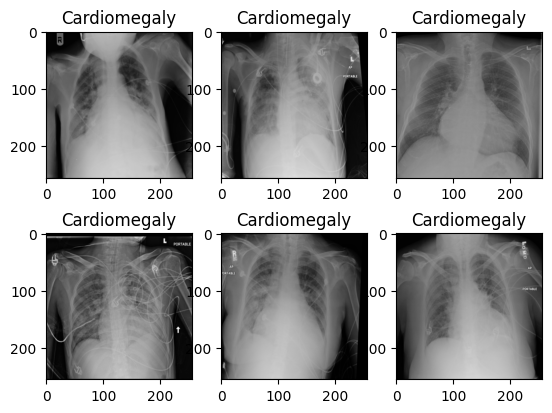

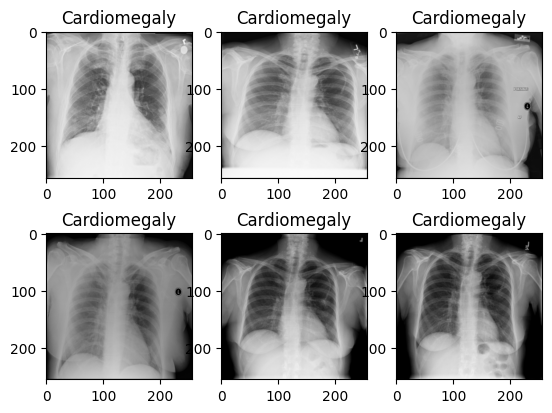

In [11]:
for idx,img in enumerate(positive_imgs[:6]):
  plt.subplot(2,3,idx+1)
  plt.title(finding)
  plt.imshow(positive_imgs[idx])
plt.show()

for idx,img in enumerate(negative_imgs[:6]):
  plt.subplot(2,3,idx+1)
  plt.title(finding)
  plt.imshow(negative_imgs[idx])
plt.show()

3. Training the Model

In [12]:
pre_trained_model = InceptionV3(input_shape=(IMAGE_HEIGHT,IMAGE_WIDTH,3),weights='imagenet',include_top=False)

for layer in pre_trained_model.layers:
  layer.trainable = False

last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output

x=layers.Flatten()(last_output)
x=layers.Dense(1024,activation='relu')(x)
x=layers.Dropout(0.2)(x)
x=layers.Dense(1,activation='sigmoid')(x)

model = Model(pre_trained_model.input,x)
model.compile(loss="binary_crossentropy",optimizer='adam',metrics=['acc'])

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [13]:
#Define our example directories and files
base_dir = "/content/medical-ai/images"
train_dir = os.path.join(base_dir,finding,'train')
test_dir = os.path.join(base_dir,finding,'test')

train_pos_dir = os.path.join(train_dir,'positive')
train_neg_dir = os.path.join(train_dir,'negative')
test_pos_dir = os.path.join(test_dir,'positive')
test_neg_dir = os.path.join(test_dir,'negative')


In [14]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False
)

val_datagen = ImageDataGenerator(rescale=1./255)

In [15]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (IMAGE_WIDTH,IMAGE_HEIGHT),
    batch_size=1,
    class_mode='binary'
)
test_generator = val_datagen.flow_from_directory(
    test_dir,
    target_size = (IMAGE_WIDTH,IMAGE_HEIGHT),
    batch_size=1,
    class_mode='binary'
)
train_steps = len(os.listdir(train_pos_dir))*2
test_steps = len(os.listdir(test_pos_dir))*2

#hata var 894 yerine 60 olması lazım

Found 232 images belonging to 2 classes.
Found 60 images belonging to 2 classes.


In [16]:
print("Train positive:", len(os.listdir(train_pos_dir)))
print("Train negative:", len(os.listdir(train_neg_dir)))
print("Test positive:", len(os.listdir(test_pos_dir)))
print("Test negative:", len(os.listdir(test_neg_dir)))


Train positive: 116
Train negative: 116
Test positive: 30
Test negative: 30


In [17]:
print("Train Positive Dir:", train_pos_dir)
print("Train Negative Dir:", train_neg_dir)
print("Test Positive Dir:", test_pos_dir)
print("Test Negative Dir:", test_neg_dir)


Train Positive Dir: /content/medical-ai/images/Cardiomegaly/train/positive
Train Negative Dir: /content/medical-ai/images/Cardiomegaly/train/negative
Test Positive Dir: /content/medical-ai/images/Cardiomegaly/test/positive
Test Negative Dir: /content/medical-ai/images/Cardiomegaly/test/negative


4.Run Model

In [31]:
#HATALI YER
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=20,
    validation_data=test_generator,
    validation_steps=test_steps,
    verbose=2
)

Epoch 1/20
232/232 - 9s - 38ms/step - acc: 0.7802 - loss: 0.4686 - val_acc: 0.7167 - val_loss: 0.5800
Epoch 2/20
232/232 - 0s - 69us/step - acc: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/20


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


232/232 - 9s - 38ms/step - acc: 0.7284 - loss: 0.5521 - val_acc: 0.7500 - val_loss: 0.4942
Epoch 4/20
232/232 - 0s - 91us/step - acc: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/20
232/232 - 8s - 35ms/step - acc: 0.7759 - loss: 0.4632 - val_acc: 0.7333 - val_loss: 0.4713
Epoch 6/20
232/232 - 0s - 68us/step - acc: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/20
232/232 - 11s - 49ms/step - acc: 0.7629 - loss: 0.5026 - val_acc: 0.7000 - val_loss: 0.5563
Epoch 8/20
232/232 - 0s - 63us/step - acc: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/20
232/232 - 9s - 40ms/step - acc: 0.7931 - loss: 0.4503 - val_acc: 0.7667 - val_loss: 0.5302
Epoch 10/20
232/232 - 0s - 63us/step - acc: 0.0000e+00 - loss: 0.0000e+00
Epoch 11/20
232/232 - 7s - 31ms/step - acc: 0.7586 - loss: 0.4990 - val_acc: 0.7500 - val_loss: 0.4995
Epoch 12/20
232/232 - 1s - 3ms/step - acc: 0.0000e+00 - loss: 0.0000e+00
Epoch 13/20
232/232 - 10s - 41ms/step - acc: 0.7629 - loss: 0.4829 - val_acc: 0.7000 - val_loss: 0.5645
Epoch 14/20
232/232 - 0s - 72

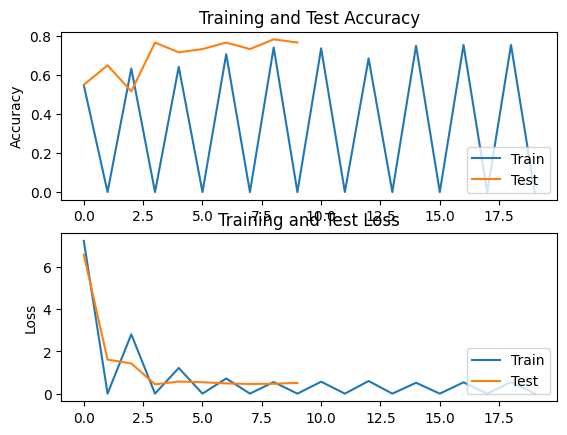

In [19]:
acc = history.history['acc']  # 'acc' değerine history.history üzerinden erişilir
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))  # Eğer val_acc kısa ise uyumlu hale getirin

plt.subplot(2, 1, 1)
plt.plot(epochs, acc, label='Train')
plt.plot(epochs[:len(val_acc)], val_acc, label='Test')  # Boyutları eşitle
plt.ylabel("Accuracy")
plt.title('Training and Test Accuracy')
plt.legend(loc='lower right')

plt.subplot(2, 1, 2)
plt.plot(epochs, loss, label='Train')
plt.plot(epochs[:len(val_loss)], val_loss, label='Test')  # Boyutları eşitle
plt.ylabel("Loss")
plt.title('Training and Test Loss')
plt.legend(loc='lower right')

plt.show()



5. Evaluating Performance

In [20]:
def predict_image(filename):
  image = Image.open(filename).resize((IMAGE_HEIGHT, IMAGE_WIDTH))
  image_np = load_image_into_numpy_array(image)
  expanded = np.expand_dims(image_np, axis=0)
  return model.predict(expanded)[0][0]

def show_df_row(row):
  image_path = row["filepath"]
  image = Image.open(image_path).resize((IMAGE_WIDTH, IMAGE_HEIGHT))
  img = load_image_into_numpy_array(image)
  expanded = np.expand_dims(img, axis=0)
  pred = model.predict(expanded)[0][0]
  guess = "neg"
  if pred > 0.5:
    guess = "pos"
  title = "Image: "+row["filename"]+" Label: "+row["label"]+" Guess: "+guess+" Score: "+str(pred)
  plt.title(title)
  plt.imshow(img)
  plt.show()
  return

In [21]:
results = []

for image in os.listdir(test_neg_dir):
  filename = test_neg_dir+"/"+image
  confidence = predict_image(filename)
  guess = 'pos' if confidence > 0.5 else 'neg'
  results.append([filename,image,"neg",guess,confidence])

  for image in os.listdir(test_pos_dir):
    filename = test_pos_dir+"/"+image
    confidence = predict_image(filename)
    guess = 'pos' if confidence > 0.5 else 'neg'
    results.append([filename,image,"pos",guess,confidence])
sorted_results = sorted(results,key=lambda x:x[4],reverse=True)
df = pd.DataFrame(data=sorted_results,columns=["filepath","filename","label","guess","confidence"])

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━

In [22]:
df.head()

,filepath,filename,label,guess,confidence
0,/content/medical-ai/images/Cardiomegaly/test/n...,00000083_000.jpg,neg,pos,1.0
1,/content/medical-ai/images/Cardiomegaly/test/p...,00004342_002.jpg,pos,pos,1.0
2,/content/medical-ai/images/Cardiomegaly/test/p...,00005532_000.jpg,pos,pos,1.0
3,/content/medical-ai/images/Cardiomegaly/test/p...,00004342_023.jpg,pos,pos,1.0
4,/content/medical-ai/images/Cardiomegaly/test/p...,00012686_003.jpg,pos,pos,1.0


5a.Example Image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


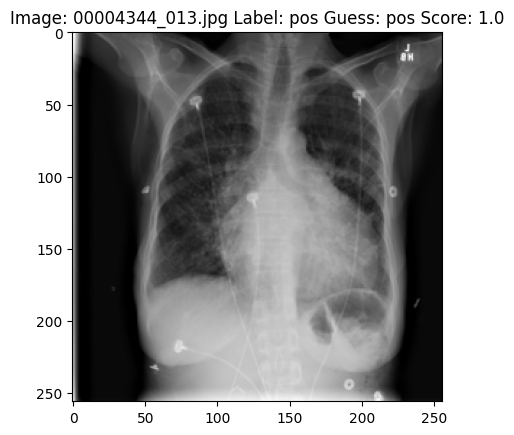

In [23]:
n =random.randint(0,len(df)-1)
show_df_row(df.iloc[n])

5b. Show Table of Images

In [24]:
df[::5][['filename','label','guess','confidence']]

,filename,label,guess,confidence
0,00000083_000.jpg,neg,pos,1.000000
5,00015304_001.jpg,pos,pos,1.000000
10,00010381_000.jpg,pos,pos,1.000000
15,00008399_007.jpg,pos,pos,1.000000
20,00004344_014.jpg,pos,pos,1.000000
...,...,...,...,...
905,00013615_052.jpg,pos,pos,0.999952
910,00013615_052.jpg,pos,pos,0.999952
915,00013615_052.jpg,pos,pos,0.999952
920,00013615_052.jpg,pos,pos,0.999952


5c.Show Histogram

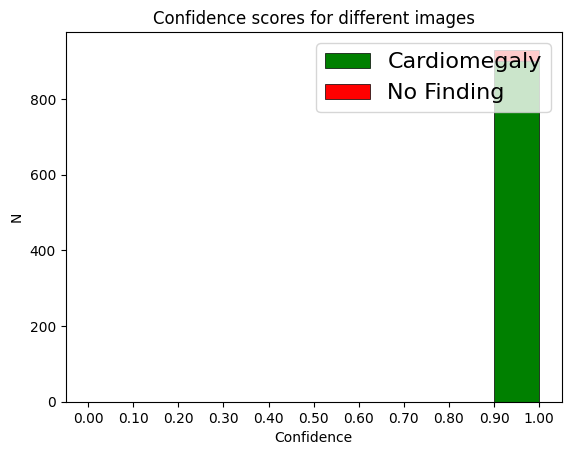

In [25]:
from matplotlib.ticker import FormatStrFormatter
pos = df.loc[df['label']=="pos"]["confidence"]
neg = df.loc[df['label']=="neg"]["confidence"]

fig,ax = plt.subplots()
n,bins,patches = plt.hist([pos,neg],np.arange(0.0,1.1,0.1).tolist(),\
                          edgecolor='black',linewidth=0.5,density=False,histtype='bar',stacked=True,\
                          color=['green','red'],label=[finding,"No Finding"])
plt.xlabel('Confidence')
plt.ylabel('N')
plt.xticks(bins)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.title('Confidence scores for different images')
plt.legend(loc='upper right',fontsize=16)
plt.show()

5d. Create Cutoff Point

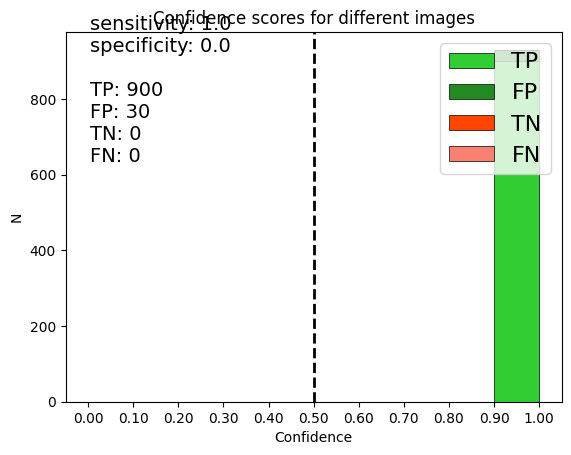

In [26]:
from matplotlib.ticker import FormatStrFormatter

def create_with_cutoff(cutoff):
    _, ax = plt.subplots()

    # Filtrelenen değerler
    TP = df.loc[(df["label"] == "pos") & (df["confidence"] > cutoff)]["confidence"]
    FP = df.loc[(df["label"] == "neg") & (df["confidence"] > cutoff)]["confidence"]
    TN = df.loc[(df["label"] == "neg") & (df["confidence"] < cutoff)]["confidence"]
    FN = df.loc[(df["label"] == "pos") & (df["confidence"] < cutoff)]["confidence"]

    # Histogram
    plt.hist([TP, FP, TN, FN], np.arange(0.0, 1.1, 0.1).tolist(),
             edgecolor='black', linewidth=0.5, density=False, histtype='bar',
             stacked=True, color=['limegreen', 'forestgreen', 'orangered', 'salmon'],  # Düzeltilen renk argümanı
             label=['TP', 'FP', 'TN', 'FN'])

    # X ve Y etiketleri
    plt.xlabel('Confidence')
    plt.ylabel('N')
    plt.xticks(np.arange(0.0, 1.1, 0.1).tolist())
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    # Başlık ve cutoff çizgisi
    plt.title('Confidence scores for different images')
    plt.axvline(cutoff, color='k', linestyle='dashed', linewidth=2)

    # Hassasiyet ve Özgüllük Hesaplama
    sens = round(len(TP) / (len(TP) + len(FN)), 2) if len(TP) + len(FN) > 0 else 0
    spec = round(len(TN) / (len(TN) + len(FP)), 2) if len(TN) + len(FP) > 0 else 0

    # İstatistik Bilgisi
    stats = (f"sensitivity: {sens}\n"
             f"specificity: {spec}\n\n"
             f"TP: {len(TP)}\n"
             f"FP: {len(FP)}\n"
             f"TN: {len(TN)}\n"
             f"FN: {len(FN)}")
    plt.text(0.05, 0.65, stats, fontsize=14, transform=ax.transAxes)

    # Açıklama ve Gösterim
    plt.legend(loc='upper right', fontsize=16)
    plt.show()

create_with_cutoff(cutoff=0.5)


5e. Show RQC Curve

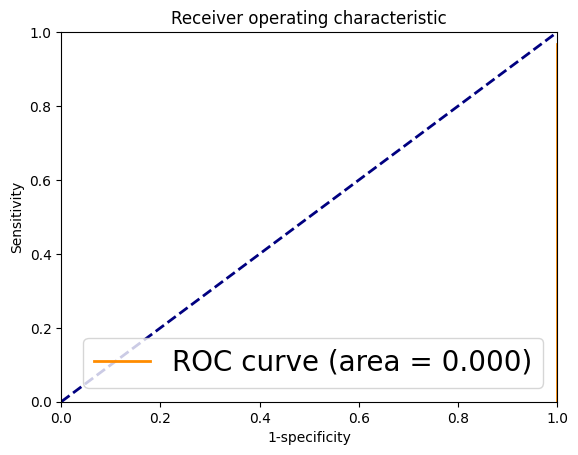

In [28]:
def create_auc_curve(classifictions):
    squares = {}
    for x in classifictions:
        conf = x[4]
        TP, FP, TN, FN = 0, 0, 0, 0
        for row in classifictions:
            assert row[2] in ('neg', 'pos')  # Etiket kontrolü
            if row[2] == 'neg':  # Negatif örnek
                if float(row[4]) < conf:
                    TN += 1
                else:
                    FP += 1
            else:  # Pozitif örnek
                if float(row[4]) > conf:
                    TP += 1
                else:
                    FN += 1
        squares[conf] = [TP, FP, TN, FN]  # Her eşik için değerler saklanır

    sens_spec = {}
    for entry in squares:
        TP, FP, TN, FN = squares[entry]
        sens = TP / float(TP + FN) if (TP + FN) > 0 else 0  # Duyarlılık
        spec = TN / float(TN + FP) if (TN + FP) > 0 else 0  # Özgüllük
        sens_spec[entry] = (1 - spec, sens)  # 1-özgüllük ve duyarlılık

    return squares, sens_spec

# AUC eğrisi oluşturma
squares, sens_spec = create_auc_curve(sorted_results)

# ROC eğrisi için koordinatlar
x = []
y = []
for point in sens_spec:
    x.append(sens_spec[point][0])  # 1-özgüllük
    y.append(sens_spec[point][1])  # Duyarlılık

# AUC hesaplama ve görselleştirme
auc = sklearn.metrics.auc(x, y)

plt.figure()
lw = 2
plt.plot(x, y, color='darkorange', lw=lw, label='ROC curve (area = %0.3f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.ylabel('Sensitivity')
plt.xlabel('1-specificity')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right", fontsize=20)
plt.show()


5f. Save Model

In [ ]:
model.save('/content/export/'+finding)
! zip -r /content/{finding}.zip /content/export/{finding}

ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=/content/export/Cardiomegaly.

Clean Up

In [ ]:
import os,signal
os.kill(os.getpid(),signal.SIGKILL)

# -------------------------------------------------------------------------------------------------------------------------------

HOCANIN KODU

In [ ]:
finding = "cardiomegaly"
finding = finding.capitalize()

In [ ]:
df = pd.read_csv("/content/medical-ai/labels.csv")
df.head()

,filename,height,width,label,xmin,ymin,xmax,ymax,view
0,00013118_008.jpg,2992,2991,Atelectasis,225.0,547.0,311.0,626.0,PA
1,00014716_007.jpg,3056,2544,Atelectasis,686.0,131.0,871.0,444.0,AP
2,00029817_009.jpg,3056,2544,Atelectasis,221.0,317.0,376.0,533.0,AP
3,00014687_001.jpg,2500,2048,Atelectasis,726.0,494.0,867.0,549.0,AP
4,00017877_001.jpg,2500,2048,Atelectasis,660.0,569.0,860.0,647.0,AP


In [ ]:
positives = df.loc[df["label"] == finding]
negatives = df.loc[df["label"] == "No Finding"]
n = len(positives)

if n == 0:
  print("No studies found! Maybe check your spelling?")
  assert (n > 0)

In [ ]:
TRAIN_RATIO = 0.8
TEST_RATIO = 0.2
n = len(positives)
TRAIN_N = int(n*TRAIN_RATIO)
TEST_N = int(n*TEST_RATIO)
print(TRAIN_N, TEST_N)

116 29


In [ ]:
train_labels = pd.concat([positives[:TRAIN_N], negatives[:TRAIN_N]])
test_labels = pd.concat([positives[TRAIN_N:], negatives[TRAIN_N:n]])

2. Preparing the Data

In [ ]:
rootdir = "/content/medical-ai/images/"
os.makedirs(rootdir+finding+"/test/positive",  exist_ok=True)
os.makedirs(rootdir+finding+"/test/negative",  exist_ok=True)
os.makedirs(rootdir+finding+"/train/positive", exist_ok=True)
os.makedirs(rootdir+finding+"/train/negative", exist_ok=True)

In [ ]:
# copy images to new directories for training purposes
for idx, image in positives[:TRAIN_N].iterrows():
  source = rootdir+image["filename"]
  dst = rootdir+finding+"/train/positive/"+image["filename"]
  shutil.copy(source, dst)

for idx, image in positives[TRAIN_N:].iterrows():
  source = rootdir+image["filename"]
  dst = rootdir+finding+"/test/positive/"+image["filename"]
  shutil.copy(source, dst)

for idx, image in negatives[:TRAIN_N].iterrows():
  source = rootdir+image["filename"]
  dst = rootdir+finding+"/train/negative/"+image["filename"]
  shutil.copy(source, dst)

for idx, image in negatives[TRAIN_N:n].iterrows():
  source = rootdir+image["filename"]
  dst = rootdir+finding+"/test/negative/"+image["filename"]
  shutil.copy(source, dst)

print("Done moving "+str(n*2)+" images to positive and negative folders.")

Done moving 292 images to positive and negative folders.


In [ ]:
from PIL import Image, ImageDraw, ImageFont

# load images into memory for visualization
positive_imgs, negative_imgs = [], []
IMAGE_HEIGHT, IMAGE_WIDTH = 299, 299

for idx, row in positives[:6].iterrows():
  image_path = rootdir+row["filename"]
  image = Image.open(image_path).resize((IMAGE_WIDTH, IMAGE_HEIGHT))
  positive_imgs.append(load_image_into_numpy_array(image))

for idx, row in negatives[:6].iterrows():
  image_path = rootdir+row["filename"]
  image = Image.open(image_path).resize((IMAGE_WIDTH, IMAGE_HEIGHT))
  negative_imgs.append(load_image_into_numpy_array(image))

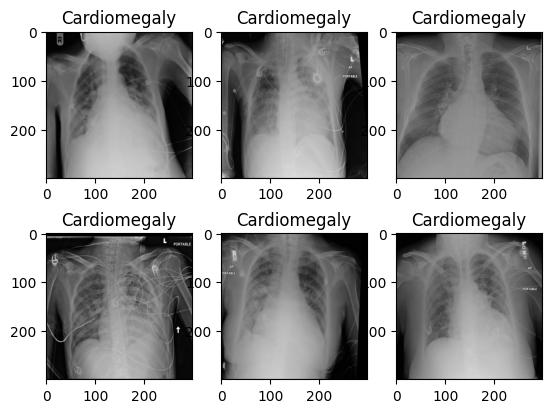

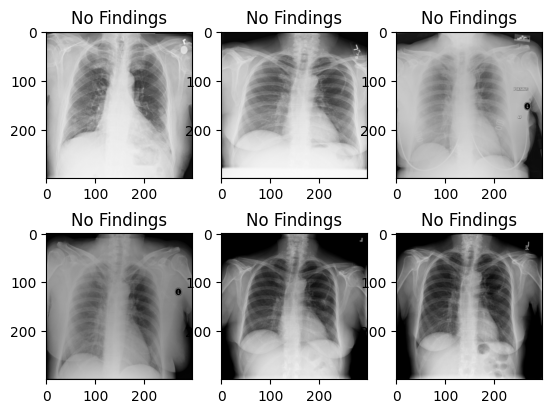

In [ ]:
for idx, img in enumerate(positive_imgs[:6]):
  plt.subplot(2, 3, idx+1)
  plt.title(finding)
  plt.imshow(positive_imgs[idx])
plt.show()

for idx, img in enumerate(negative_imgs[:6]):
  plt.subplot(2, 3, idx+1)
  plt.title("No Findings")
  plt.imshow(negative_imgs[idx])
plt.show()

3. Running the Model

In [ ]:
# Define our example directories and files
base_dir = rootdir = "/content/medical-ai/images/"
train_dir = os.path.join(base_dir, finding, 'train')
test_dir = os.path.join(base_dir, finding, 'test')

train_pos_dir = os.path.join(train_dir, 'positive')
train_neg_dir = os.path.join(train_dir, 'negative')
test_pos_dir = os.path.join(test_dir, 'positive')
test_neg_dir = os.path.join(test_dir, 'negative')

In [ ]:
BATCH_SIZE = 64
IMG_SIZE = (299, 299)
IMG_SHAPE = IMG_SIZE + (3,)
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)
validation_dataset = tf.keras.utils.image_dataset_from_directory(test_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)

Found 232 files belonging to 2 classes.
Found 60 files belonging to 2 classes.


3.1 Define the Base Model

In [ ]:
# Define the base model using InceptionV3
base_model = tf.keras.applications.InceptionV3(
    input_shape=IMG_SHAPE,
    include_top=False,  # Exclude the final classification layer
    weights='imagenet'  # Load weights pre-trained on ImageNet
)

# Freeze the base model to keep the pre-trained weights unchanged
base_model.trainable = False

3.2 Data Augmentation

In [ ]:
# Define data augmentation layers to prevent overfitting
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.10),                    # Small rotation
    tf.keras.layers.RandomTranslation(0.05, 0.05),           # Translation
    tf.keras.layers.RandomContrast(0.1),                     # Contrast adjustment
    tf.keras.layers.RandomBrightness(0.1),                   # Brightness adjustment
    tf.keras.layers.RandomZoom(0.1, 0.1)])                   # Random zoom

3.3 Putting it together

In [ ]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs) # Apply data augmentation
x = tf.keras.applications.inception_v3.preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# Define the complete model
model = tf.keras.Model(inputs, outputs)

# Compile the model with appropriate optimizer, loss function, and metrics
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

3.4 Define Callbacks

In [ ]:
# Define early stopping callback to stop training when validation loss doesn't improve
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',           # Monitor validation loss
    patience=5,                   # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True     # Restore model weights from the epoch with the best value of the monitored quantity
)

4. Train the Model

In [ ]:
# Set the number of epochs for initial training
initial_epochs = 40

# Train the model with early stopping
history = model.fit(
    train_dataset,
    epochs=initial_epochs,
    validation_data=validation_dataset,
    callbacks=[early_stopping]
)

Epoch 1/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 27s 4s/step - accuracy: 0.5332 - loss: 0.7504 - val_accuracy: 0.6000 - val_loss: 0.6502
Epoch 2/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 442ms/step - accuracy: 0.5675 - loss: 0.7351 - val_accuracy: 0.6333 - val_loss: 0.6255
Epoch 3/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 491ms/step - accuracy: 0.5450 - loss: 0.7656 - val_accuracy: 0.7333 - val_loss: 0.6125
Epoch 4/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 448ms/step - accuracy: 0.5717 - loss: 0.6898 - val_accuracy: 0.7000 - val_loss: 0.6132
Epoch 5/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 507ms/step - accuracy: 0.5751 - loss: 0.7041 - val_accuracy: 0.6833 - val_loss: 0.5921
Epoch 6/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 622ms/step - accuracy: 0.5918 - loss: 0.6627 - val_accuracy: 0.6667 - val_loss: 0.5836
Epoch 7/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 405ms/step - accuracy: 0.5877 - loss: 0.6571 - val_accuracy: 0.7333 - val_loss: 0.5878
Epoch 8/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 443ms/step - accuracy: 0.5607 - loss: 0.6758 - val_accuracy: 0.7500 - val_loss: 0

4.1 Fine-Tune the Model

In [ ]:
base_model.trainable = True
fine_tune_at = 249 # specific to this architecture

# Freeze all layers before the fine_tune_at layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Recompile the model with a lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Set the number of epochs for fine-tuning
fine_tune_epochs = 40
total_epochs = initial_epochs + fine_tune_epochs  # Total epochs

# Continue training the model with fine-tuning
history_fine = model.fit(
    train_dataset,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],  # Start from the last epoch of initial training
    validation_data=validation_dataset,
    callbacks=[early_stopping]  # Use early stopping
)

Epoch 40/80
4/4 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.7796 - loss: 0.4632 - val_accuracy: 0.7667 - val_loss: 0.4565
Epoch 41/80
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 594ms/step - accuracy: 0.7517 - loss: 0.4858 - val_accuracy: 0.7667 - val_loss: 0.4544
Epoch 42/80
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 542ms/step - accuracy: 0.8174 - loss: 0.4406 - val_accuracy: 0.7667 - val_loss: 0.4532
Epoch 43/80
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 525ms/step - accuracy: 0.7983 - loss: 0.4059 - val_accuracy: 0.7667 - val_loss: 0.4548
Epoch 44/80
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 469ms/step - accuracy: 0.8177 - loss: 0.4388 - val_accuracy: 0.7833 - val_loss: 0.4537


4.2 Plotting the progress

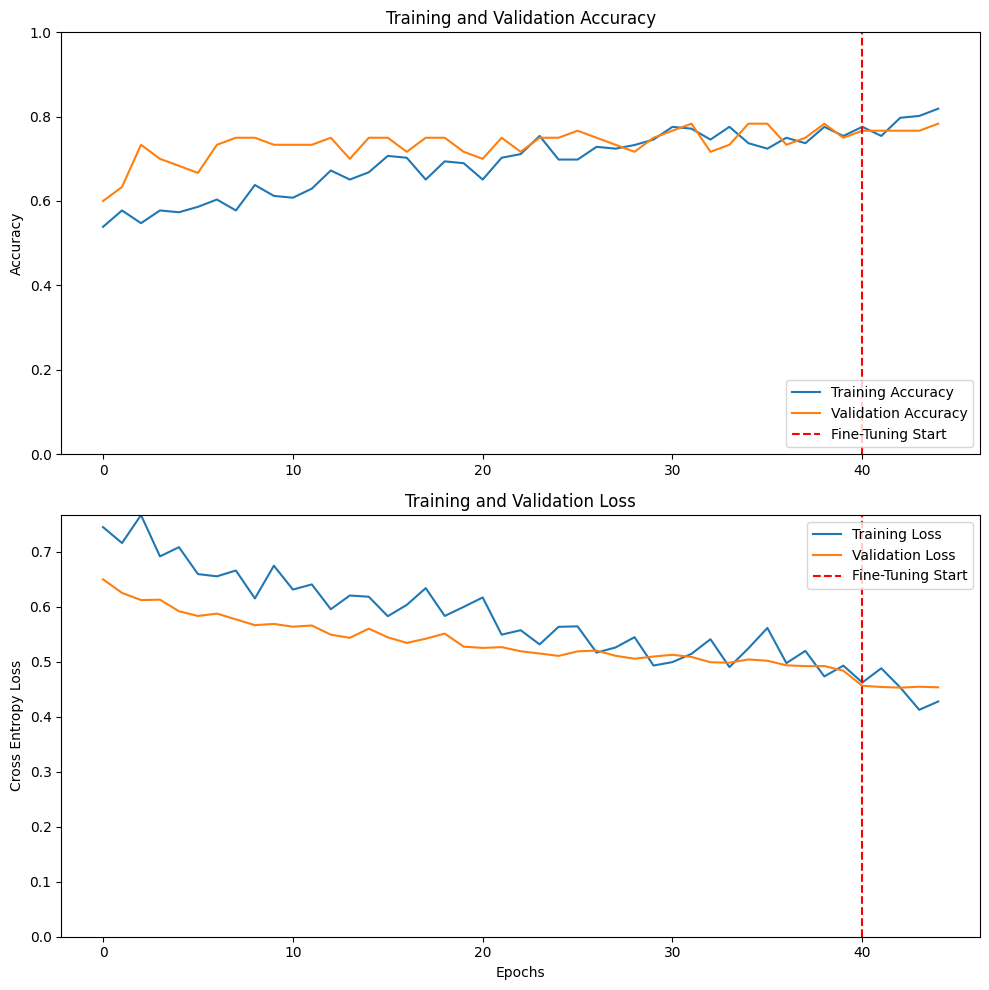

In [ ]:
# Combine histories
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

# Total epochs
total_epochs = len(acc)
fine_tune_start = initial_epochs  # Epoch where fine-tuning starts

plt.figure(figsize=(10, 10))

# Accuracy plot
plt.subplot(2, 1, 1)
plt.plot(range(total_epochs), acc, label='Training Accuracy')
plt.plot(range(total_epochs), val_acc, label='Validation Accuracy')
plt.axvline(x=fine_tune_start, color='r', linestyle='--', label='Fine-Tuning Start')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.title('Training and Validation Accuracy')

# Loss plot
plt.subplot(2, 1, 2)
plt.plot(range(total_epochs), loss, label='Training Loss')
plt.plot(range(total_epochs), val_loss, label='Validation Loss')
plt.axvline(x=fine_tune_start, color='r', linestyle='--', label='Fine-Tuning Start')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy Loss')
plt.ylim([0, max(max(loss), max(val_loss))])
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')

plt.tight_layout()
plt.show()


5. Evaluating Performance

In [ ]:
def predict_image(filename):
  image = Image.open(filename).resize((IMAGE_HEIGHT, IMAGE_WIDTH))
  image_np = load_image_into_numpy_array(image)
  expanded = np.expand_dims(image_np, axis=0)
  return model.predict(expanded)[0][0]

def show_df_row(row):
  image_path = row["filepath"]
  image = Image.open(image_path).resize((IMAGE_WIDTH, IMAGE_HEIGHT))
  img = load_image_into_numpy_array(image)
  expanded = np.expand_dims(img, axis=0)
  pred = model.predict(expanded)[0][0]
  guess = "neg"
  if pred > 0.5:
    guess = "pos"
  title = "Image: "+row["filename"]+" Label: "+row["label"]+" Guess: "+guess+" Score: "+str(pred)
  plt.title(title)
  plt.imshow(img)
  plt.show()
  return

In [ ]:
results = []
for image in os.listdir(test_neg_dir):
  filename = test_neg_dir+"/"+image
  confidence = predict_image(filename)
  guess = 'pos' if confidence > 0.5 else 'neg'
  results.append([filename, image, "neg", guess, confidence])

for image in os.listdir(test_pos_dir):
  filename = test_pos_dir+"/"+image
  confidence = predict_image(filename)
  guess = 'pos' if confidence > 0.5 else 'neg'
  results.append([filename, image, "pos", guess, confidence])

sorted_results = sorted(results, key=lambda x: x[4], reverse=True)
df = pd.DataFrame(data=sorted_results, columns=["filepath","filename","label","guess","confidence"])

print("Done inference!")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━

In [ ]:
df.head()

,filepath,filename,label,guess,confidence
0,/content/medical-ai/images/Cardiomegaly/test/p...,00013615_052.jpg,pos,pos,0.990211
1,/content/medical-ai/images/Cardiomegaly/test/p...,00030206_013.jpg,pos,pos,0.989531
2,/content/medical-ai/images/Cardiomegaly/test/p...,00004342_002.jpg,pos,pos,0.968344
3,/content/medical-ai/images/Cardiomegaly/test/p...,00011557_003.jpg,pos,pos,0.943750
4,/content/medical-ai/images/Cardiomegaly/test/p...,00010381_000.jpg,pos,pos,0.942196


5.1 Example image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


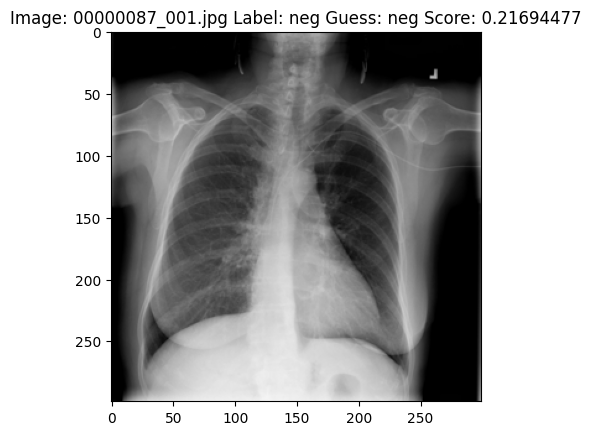

In [ ]:
import random
n = random.randint(0, len(df)-1)
show_df_row(df.iloc[n])

5.2 Show Table of images

In [ ]:
df[::5][['filename', 'label',"guess","confidence"]]

,filename,label,guess,confidence
0,00013615_052.jpg,pos,pos,0.990211
5,00004893_085.jpg,pos,pos,0.940321
10,00004342_023.jpg,pos,pos,0.891089
15,00000094_000.jpg,neg,pos,0.813779
20,00022706_001.jpg,pos,pos,0.695554
25,00001373_039.jpg,pos,pos,0.669016
30,00028607_000.jpg,pos,pos,0.567085
35,00015064_001.jpg,pos,pos,0.529192
40,00008399_007.jpg,pos,neg,0.358208
45,00000090_007.jpg,neg,neg,0.313964


5.3 Show Histogram

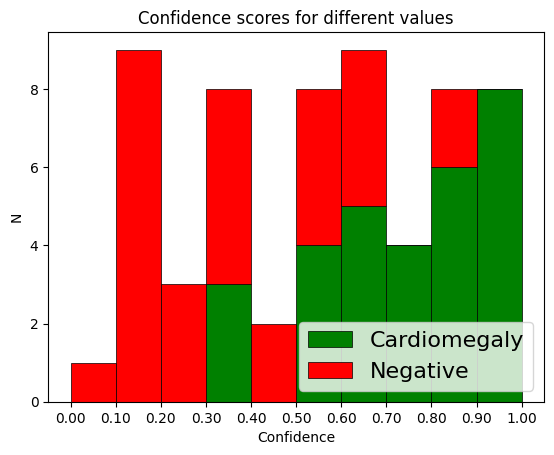

In [ ]:
pos = df.loc[df['label'] == "pos"]["confidence"]
neg = df.loc[df['label'] == "neg"]["confidence"]
fig, ax = plt.subplots()
n, bins, patches = plt.hist([pos,neg], np.arange(0.0, 1.1, 0.1).tolist(), edgecolor='black', linewidth=0.5, density=False, histtype='bar', stacked=True, color=['green', 'red'], label=[finding, 'Negative'])
plt.xlabel('Confidence')
plt.ylabel('N')
plt.xticks(bins)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.title('Confidence scores for different values')
plt.legend(loc="lower right", fontsize=16)
plt.show()

5.4 Create cutoff point

In [ ]:
cutoff = 0.24 #@param {type:"slider", min:0, max:1, step:0.01}

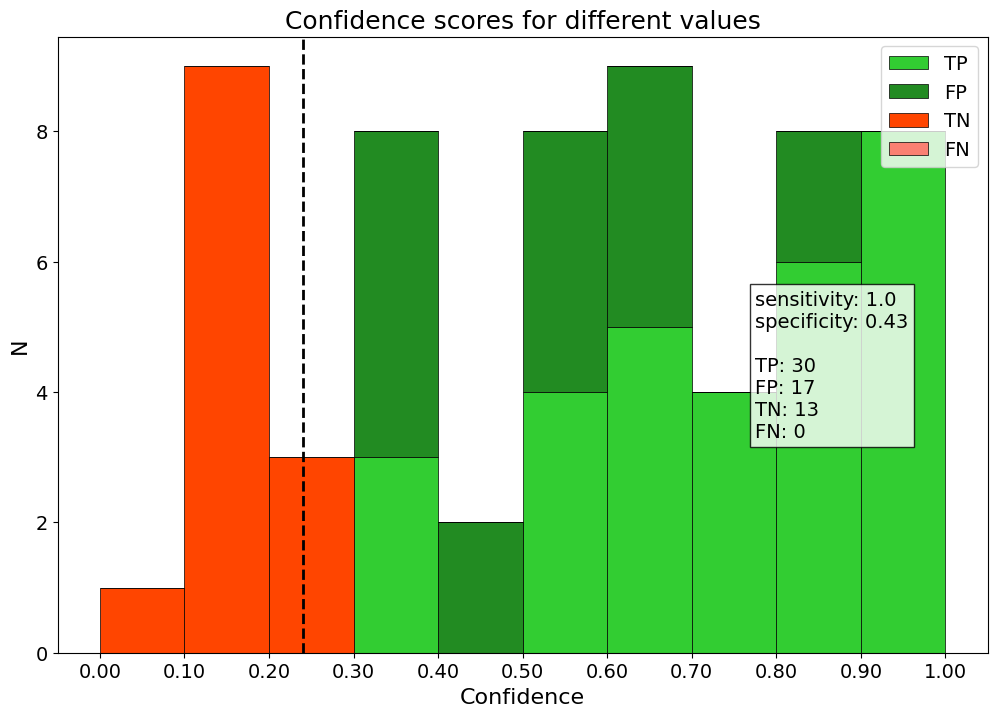

In [ ]:
def create_with_cutoff(cutoff):
    __, ax = plt.subplots(figsize=(12, 8))  # Increased figure size
    TP = df.loc[(df['label'] == "pos") & (df["confidence"] > cutoff)]["confidence"]
    FP = df.loc[(df['label'] == "neg") & (df["confidence"] > cutoff)]["confidence"]
    FN = df.loc[(df['label'] == "pos") & (df["confidence"] < cutoff)]["confidence"]
    TN = df.loc[(df['label'] == "neg") & (df["confidence"] < cutoff)]["confidence"]

    # Plot the histogram
    plt.hist([TP, FP, TN, FN], bins=np.arange(0.0, 1.1, 0.1).tolist(),
             edgecolor='black', linewidth=0.5, density=False, histtype='bar',
             stacked=True, color=['limegreen', 'forestgreen', 'orangered', 'salmon'],
             label=['TP', 'FP', 'TN', 'FN'])

    plt.xlabel('Confidence', fontsize=16)
    plt.ylabel('N', fontsize=16)
    plt.xticks(np.arange(0.0, 1.1, 0.1), fontsize=14)
    plt.yticks(fontsize=14)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    plt.title('Confidence scores for different values', fontsize=18)
    plt.axvline(cutoff, color='k', linestyle='dashed', linewidth=2)
    plt.legend(loc="upper right", fontsize=14)  # Adjusted legend location to avoid overlap

    # Calculate statistics
    sens = round(len(TP) / (len(TP) + len(FN)), 2)
    spec = round(len(TN) / (len(TN) + len(FP)), 2)
    stats = f"sensitivity: {sens}\nspecificity: {spec}\n\nTP: {len(TP)}\nFP: {len(FP)}\nTN: {len(TN)}\nFN: {len(FN)}"

    # Display stats in a box to make it more readable
    plt.text(0.75, 0.35, stats, fontsize=14, transform=ax.transAxes,
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))

    plt.show()

create_with_cutoff(cutoff)


5.5 Show ROC Curve

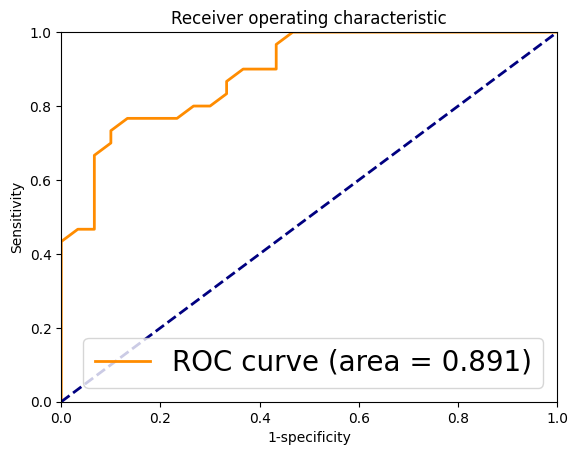

In [ ]:
def create_auc_curve(classifications):
  squares = {}
  for x in classifications:
    conf = x[4]
    TP, FP, TN, FN = 0, 0, 0, 0
    for row in classifications:
      assert (row[2] == "neg" or row[2] == "pos")
      if row[2] == "neg":
        if float(row[4]) < conf: TN += 1
        else: FP += 1
      else:
        if float(row[4]) > conf: TP += 1
        else: FN += 1
    squares[conf] = [TP, FP, TN, FN]
  # now we have a list of stuff: convert to
  sens_spec = {}
  for entry in squares:
    sens = squares[entry][0] / float(squares[entry][0] + squares[entry][3])
    spec = squares[entry][2] / float(squares[entry][2] + squares[entry][1])
    sens_spec[entry] = (1-spec, sens)
  return squares, sens_spec

squares, sens_spec = create_auc_curve(sorted_results)

x = []
y = []
for point in sens_spec.keys():
  x.append(sens_spec[point][0])
  y.append(sens_spec[point][1])

auc = sklearn.metrics.auc(x, y)

plt.figure()
lw = 2
plt.plot(x, y, color='darkorange', lw=lw, label='ROC curve (area = %0.3f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.ylabel('Sensitivity')
plt.xlabel('1-specificity')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right", fontsize=20)
plt.show()

5.6 Save Model

In [ ]:
model.export('/content/export/'+finding)
!zip -r /content/{finding}.zip /content/export/{finding}